In [34]:
import pandas as pd

def load_telecom_data(file_path):
    """
    Memory-optimized telecom data loading with aggregation and feature combination.
    Drops Country Code, sums activities by Square ID and Time Interval,
    and combines SMS-in/out into SMS and Call-in/out into Call.
    """
    try:
        # Define data types to reduce memory usage
        dtype_dict = {
            "Square ID": 'int16',  # Assuming Square IDs are < 32k
            "Time Interval (ms)": 'int64',
            "Country Code": 'int8',  # Will be loaded then effectively dropped by aggregation
            "SMS-in activity": 'float32',
            "SMS-out activity": 'float32', 
            "Call-in activity": 'float32',
            "Call-out activity": 'float32',
            "Internet traffic activity": 'float32'
        }
        
        # These are the names for the 8 columns read from the CSV
        column_names_from_csv = [
            "Square ID",
            "Time Interval (ms)",
            "Country Code", 
            "SMS-in activity",
            "SMS-out activity",
            "Call-in activity",
            "Call-out activity",
            "Internet traffic activity"
        ]

        # Load with optimized data types, reading the first 8 columns
        df = pd.read_csv(
            file_path,
            sep='\t',
            header=None,
            names=column_names_from_csv, # Use names for the 8 columns being read
            dtype=dtype_dict,
            usecols=range(8) 
        )

        # Convert timestamp more efficiently
        df['Time Interval (GMT+1)'] = pd.to_datetime(df['Time Interval (ms)'], unit='ms', utc=True)
        df['Time Interval (GMT+1)'] = df['Time Interval (GMT+1)'].dt.tz_convert('Europe/Rome')

        # Define columns for aggregation
        activity_cols_to_sum = [
            "SMS-in activity",
            "SMS-out activity",
            "Call-in activity",
            "Call-out activity",
            "Internet traffic activity"
        ]
        
        # Columns to group by. This will make each row unique per Square ID and Time Interval.
        group_by_cols = ["Square ID", "Time Interval (GMT+1)"]

        # Create a dictionary for aggregation functions
        agg_dict = {col: 'sum' for col in activity_cols_to_sum}

        # Perform the groupby and aggregation
        # This sums the activities for each group and drops 'Country Code' and 'Time Interval (ms)'
        # as they are not in group_by_cols and not in agg_dict.
        df_aggregated = df.groupby(group_by_cols, as_index=False).agg(agg_dict)
        
        # Combine SMS activities and Call activities
        df_aggregated['SMS activity'] = df_aggregated['SMS-in activity'] + df_aggregated['SMS-out activity']
        df_aggregated['Call activity'] = df_aggregated['Call-in activity'] + df_aggregated['Call-out activity']
        
        # Drop the original individual SMS and Call columns
        df_aggregated = df_aggregated.drop(columns=[
            'SMS-in activity', 
            'SMS-out activity', 
            'Call-in activity', 
            'Call-out activity'
        ])
        
        print(f"Memory usage after aggregation: {df_aggregated.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        return df_aggregated

    except Exception as e:
        print(f"An error occurred while loading and aggregating the data: {e}")
        return None

In [25]:
file_pattern = 'data/reduced/sms-call-internet-mi*'
telecom_df = load_telecom_data('data/reduced/sms-call-internet-mi-2013-12-29.txt')
#telecom_df['Precipitation_Grid_ID'] = telecom_df['Square ID'].apply(map_milan_to_precipitation_grid)
print(telecom_df.head())
print(telecom_df['Square ID'].unique())
print("\nMapping Milan Grid cells to Precipitazioni Grid cells:")

Memory usage: 45.09 MB
   Square ID  Time Interval (ms)  Country Code  SMS-in activity  \
0       2526       1388271600000             0         0.177805   
1       2526       1388271600000            39              NaN   
2       2526       1388272200000             0         0.043077   
3       2526       1388272200000            39              NaN   
4       2526       1388272800000             0         0.373776   

   SMS-out activity  Call-in activity  Call-out activity  \
0               NaN               NaN                NaN   
1          0.062296               NaN           0.067359   
2               NaN               NaN                NaN   
3               NaN          0.105373                NaN   
4               NaN               NaN                NaN   

   Internet traffic activity     Time Interval (GMT+1)  
0                        NaN 2013-12-29 00:00:00+01:00  
1                   5.357473 2013-12-29 00:00:00+01:00  
2                        NaN 2013-12-29 00

In [26]:
def generate_central_grid_lists():
    """
    Directly generates the lists of cell IDs to keep and discard
    to form a 50x50 central square on a 100x100 grid.

    This is the most efficient method if you need the complete lists.
    """
    all_cell_ids = set(range(1, 10001))
    cells_to_keep = set()

    # Define the rows and columns to keep
    for row in range(26, 76):  # Corresponds to rows 26 to 75
        for col in range(26, 76):  # Corresponds to columns 26 to 75
            cell_id = (row - 1) * 100 + col
            cells_to_keep.add(cell_id)

    # Return the results as sorted list
    return sorted(list(cells_to_keep))

SQUARE_ID_to_keep = generate_central_grid_lists()
print(f"Number of cells to keep: {len(SQUARE_ID_to_keep)}")
pr

Number of cells to keep: 2500


NameError: name 'pr' is not defined

In [ ]:
import os
import glob

# Create the reduced directory if it doesn't exist
os.makedirs('data/reduced', exist_ok=True)

# Find all files matching the pattern
file_pattern = 'data/sms-call-internet-mi*'
files = glob.glob(file_pattern)

print(f"Found {len(files)} files matching pattern: {file_pattern}")

for file_path in files:
    try:
        # Extract filename for the output
        filename = os.path.basename(file_path)
        output_path = f'data/reduced/{filename}'
        
        print(f"Processing: {filename}")
        
        # Load the data using the existing function
        df = load_telecom_data(file_path)
        
        if df is not None:
            # Filter data to keep only the specified Square IDs
            filtered_df = df[df['Square ID'].isin(SQUARE_ID_to_keep)]
            
            # Save the filtered dataframe
            filtered_df.to_csv(output_path, sep='\t', index=False, header=False)
            
            print(f"  Original shape: {df.shape}")
            print(f"  Filtered shape: {filtered_df.shape}")
            print(f"  Saved to: {output_path}")
            
        else:
            print(f"  Failed to load {filename}")
            
    except Exception as e:
        print(f"  Error processing {filename}: {e}")

print("\nProcessing complete!")

In [ ]:
import os
from datetime import datetime

# Save meteo_data into daily files

# Create directory for daily meteo files
os.makedirs('data/meteo_daily', exist_ok=True)

# Group meteo data by date
meteo_data['Date'] = meteo_data['Timestamp'].dt.date
grouped_meteo = meteo_data.groupby('Date')

print(f"Processing {len(grouped_meteo)} days of meteo data...")

for date, daily_data in grouped_meteo:
    # Format filename
    date_str = date.strftime('%Y-%m-%d')
    output_file = f'data/meteo_daily/meteo_milano_{date_str}.csv'
    
    # Save daily data
    daily_data.drop('Date', axis=1).to_csv(output_file, index=False)
    
    print(f"Saved {len(daily_data)} records for {date_str}")

print(f"\nDaily meteo files saved to 'data/meteo_daily/' directory")


Processing 62 days of meteo data...
Saved 576 records for 2013-11-01
Saved 576 records for 2013-11-02
Saved 576 records for 2013-11-03
Saved 572 records for 2013-11-04
Saved 520 records for 2013-11-05
Saved 516 records for 2013-11-06
Saved 568 records for 2013-11-07
Saved 564 records for 2013-11-08
Saved 556 records for 2013-11-09
Saved 568 records for 2013-11-10
Saved 564 records for 2013-11-11
Saved 412 records for 2013-11-12
Saved 264 records for 2013-11-13
Saved 556 records for 2013-11-14
Saved 552 records for 2013-11-15
Saved 556 records for 2013-11-16
Saved 572 records for 2013-11-17
Saved 544 records for 2013-11-18
Saved 568 records for 2013-11-19
Saved 552 records for 2013-11-20
Saved 360 records for 2013-11-21
Saved 320 records for 2013-11-22
Saved 344 records for 2013-11-23
Saved 556 records for 2013-11-24
Saved 572 records for 2013-11-25
Saved 564 records for 2013-11-26
Saved 548 records for 2013-11-27
Saved 572 records for 2013-11-28
Saved 528 records for 2013-11-29
Saved 5

In [ ]:
import math

def map_milan_to_precipitation_grid(milan_grid_cell_number: int) -> int:
    """
    Maps a cell number from the Milan Grid to its corresponding cell number
    in the Milan - Precipitazioni Grid.

    The Milan Grid is assumed to be 100x100, numbered from 1 (bottom-left)
    increasing across rows and then up columns.
    The Precipitazioni Grid is a 2x2 grid numbered as:
    1 (top-left), 2 (top-right), 3 (bottom-right), 4 (bottom-left).

    Args:
        milan_grid_cell_number: An integer representing the cell number in the
                                Milan Grid (1 to 10000).

    Returns:
        An integer representing the corresponding cell number in the
        Milan - Precipitazioni Grid (1, 2, 3, or 4).

    Raises:
        ValueError: If the milan_grid_cell_number is out of the valid range.
    """
    if not (1 <= milan_grid_cell_number <= 10000):
        print("Invalid Milan Grid Cell Number:", milan_grid_cell_number)
        raise ValueError("Milan grid cell number must be between 1 and 10000.")

    # Calculate row and column in the Milan Grid (1-indexed)
    m_row = math.ceil(milan_grid_cell_number / 100)
    m_col = (milan_grid_cell_number - 1) % 100 + 1

    # Determine the corresponding Precipitazioni Grid cell
    if 51 <= m_row <= 100:  # Top half of the Milan Grid
        if 1 <= m_col <= 50:  # Left half of the Milan Grid
            return 1  # Top-Left (Precipitazioni cell 1)
        else:  # 51 <= m_col <= 100  # Right half of the Milan Grid
            return 2  # Top-Right (Precipitazioni cell 2)
    else:  # 1 <= m_row <= 50  # Bottom half of the Milan Grid
        if 1 <= m_col <= 50:  # Left half of the Milan Grid
            return 4  # Bottom-Left (Precipitazioni cell 4)
        else:  # 51 <= m_col <= 100  # Right half of the Milan Grid
            return 3  # Bottom-Right (Precipitazioni cell 3)

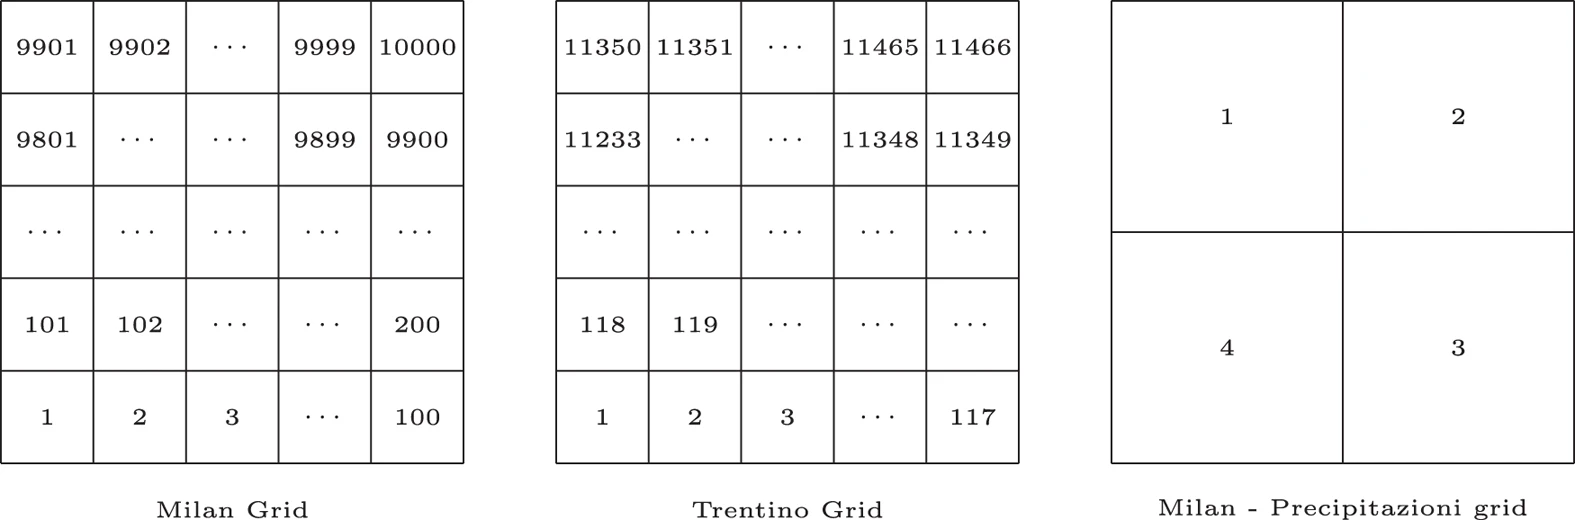

Columns after merge:
['Square ID', 'Hour', 'SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity', 'Internet traffic activity', 'Precipitation_Grid_ID', 'Square_ID', 'intensity', 'coverage', 'Type']
Merged dataset shape: (14307507, 11)

First 5 rows of merged data:
   Milan_Grid_Square_ID                      Hour  SMS-in activity  \
0                     1 2013-11-01 00:00:00+01:00         1.163624   
1                     1 2013-11-01 01:00:00+01:00         0.415579   
2                     1 2013-11-01 02:00:00+01:00         1.152067   
3                     1 2013-11-01 03:00:00+01:00         0.354453   
4                     1 2013-11-01 04:00:00+01:00         0.166924   

   SMS-out activity  Call-in activity  Call-out activity  \
0          0.770031          0.190564           0.194139   
1          0.300391          0.027925           0.135964   
2          0.895724          0.001787           0.026137   
3          0.511192          0.005362           0

In [36]:
import glob
import os

milan_days_off_2013 = [
    # November 2013
    '2013-11-01',  # Public Holiday: All Saints' Day
    '2013-11-02',  # Weekend
    '2013-11-03',  # Weekend
    '2013-11-09',  # Weekend
    '2013-11-10',  # Weekend
    '2013-11-16',  # Weekend
    '2013-11-17',  # Weekend
    '2013-11-23',  # Weekend
    '2013-11-24',  # Weekend
    '2013-11-30',  # Weekend
    
    # December 2013
    '2013-12-01',  # Weekend
    '2013-12-07',  # Public Holiday: Feast of St. Ambrose & Weekend
    '2013-12-08',  # Public Holiday: Immaculate Conception & Weekend
    '2013-12-14',  # Weekend
    '2013-12-15',  # Weekend
    '2013-12-21',  # Weekend
    '2013-12-22',  # Weekend
    '2013-12-25',  # Public Holiday: Christmas Day
    '2013-12-26',  # Public Holiday: St. Stephen's Day
    '2013-12-28',  # Weekend
    '2013-12-29'   # Weekend
]

def merge_telecom_weather_data(telecom_file_path, weather_file_path):
    """
    Merge telecom and weather data for a single day.
    
    Args:
        telecom_file_path (str): Path to the telecom data file
        weather_file_path (str): Path to the weather data file
    
    Returns:
        pandas.DataFrame: Merged dataframe or None if error occurs
    drop fields from final dataset 
    'Weather_Grid_Square_ID', 'Time Interval (ms)', 'Timestamp', 'Precipitation_Grid_ID', 'Square_ID'
    """
    try:
        # Load telecom data
        telecom_df = load_telecom_data(telecom_file_path)
        if telecom_df is None:
            print(f"Failed to load telecom data from {telecom_file_path}")
            return None
        

        
        # Add is_day_off column based on milan_days_off_2013 list
        telecom_df['is_day_off'] = telecom_df['Time Interval (GMT+1)'].dt.date.astype(str).isin(milan_days_off_2013).astype(int)
        
        # Map Milan grid cells to precipitation grid
        telecom_df['Precipitation_Grid_ID'] = telecom_df['Square ID'].apply(map_milan_to_precipitation_grid)
        
        # Load weather data
        weather_df = pd.read_csv(weather_file_path)
        weather_df['Timestamp'] = pd.to_datetime(weather_df['Timestamp'])
        
        # Localize weather data timestamps to match telecom data timezone
        weather_df['Timestamp'] = weather_df['Timestamp'].dt.tz_localize('Europe/Rome')
        
        print(f"Loaded telecom data: {telecom_df.shape}")
        print(f"Loaded weather data: {weather_df.shape}")
        
        # Merge telecom and weather data
        merged_df = telecom_df.merge(
            weather_df,
            left_on=['Precipitation_Grid_ID', 'Time Interval (GMT+1)'],
            right_on=['Square_ID', 'Timestamp'],
            how='inner',
            suffixes=('_telecom', '_weather')
        )
        
        # Drop unwanted columns
        columns_to_drop = ['Weather_Grid_Square_ID', 'Time Interval (ms)', 'Timestamp', 'Precipitation_Grid_ID', 'Square_ID']
        merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])
        
        # Rename columns for clarity
        merged_df = merged_df.rename(columns={
            'Square ID': 'Milan_Grid_Square_ID'
        })
        
        # Reorder columns to make Time Interval (GMT+1) the second column
        cols = merged_df.columns.tolist()
        cols.remove('Time Interval (GMT+1)')
        cols.insert(1, 'Time Interval (GMT+1)')
        merged_df = merged_df[cols]
        
        print(f"Merged data: {merged_df.shape}")
        
        return merged_df
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None
    except Exception as e:
        print(f"Error merging data: {e}")
        return None

# Test the function with multiple files

# Get all telecom files
telecom_files = glob.glob('data/reduced/sms-call-internet-mi*.txt')
weather_files = glob.glob('data/meteo_daily/meteo_milano_*.csv')

print(f"Found {len(telecom_files)} telecom files")
print(f"Found {len(weather_files)} weather files")

# Create merged directory
os.makedirs('data/merged', exist_ok=True)

# Process each pair of files
merged_count = 0
for telecom_file in telecom_files:
    # Extract date from telecom filename
    date_part = telecom_file.split('-')[-3:]  # Get last 3 parts: ['2013', '12', '29.txt']
    date_str = f"{date_part[0]}-{date_part[1]}-{date_part[2].replace('.txt', '')}"
    
    # Find corresponding weather file
    weather_file = f'data/meteo_daily/meteo_milano_{date_str}.csv'
    
    if os.path.exists(weather_file):
        print(f"\nProcessing {date_str}...")
        
        # Merge the data
        merged_df = merge_telecom_weather_data(telecom_file, weather_file)
        
        if merged_df is not None:
            # Save the merged file
            output_file = f'data/merged/merged_{date_str}.csv'
            merged_df.to_csv(output_file, index=False)
            print(f"Saved merged data to: {output_file}")
            merged_count += 1
        else:
            print(f"Failed to merge data for {date_str}")
    else:
        print(f"No weather file found for {date_str}")

print(f"\nSuccessfully merged {merged_count} files")


merge_telecom_weather_data


Found 62 telecom files
Found 62 weather files

Processing 2013-11-01...
Memory usage after aggregation: 7.55 MB
Loaded telecom data: (359991, 7)
Loaded weather data: (576, 5)
Merged data: (359991, 9)
Saved merged data to: data/merged/merged_2013-11-01.csv

Processing 2013-11-02...
Memory usage after aggregation: 7.55 MB
Loaded telecom data: (359990, 7)
Loaded weather data: (576, 5)
Merged data: (359990, 9)
Saved merged data to: data/merged/merged_2013-11-02.csv

Processing 2013-11-03...
Memory usage after aggregation: 7.55 MB
Loaded telecom data: (359978, 7)
Loaded weather data: (576, 5)
Merged data: (359978, 9)
Saved merged data to: data/merged/merged_2013-11-03.csv

Processing 2013-11-04...
Memory usage after aggregation: 7.55 MB
Loaded telecom data: (359976, 7)
Loaded weather data: (572, 5)
Merged data: (357476, 9)
Saved merged data to: data/merged/merged_2013-11-04.csv

Processing 2013-11-05...
Memory usage after aggregation: 7.55 MB
Loaded telecom data: (359977, 7)
Loaded weather 

<function __main__.merge_telecom_weather_data(telecom_file_path, weather_file_path)>

In [ ]:
import pandas as pd
pd.read_csv('data/calendar.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              61 non-null     object
 1   DayOfWeek         61 non-null     object
 2   IsWeekend         61 non-null     bool  
 3   SignificantEvent  32 non-null     object
dtypes: bool(1), object(3)
memory usage: 1.6+ KB


In [35]:
telecom_file = 'data/reduced/sms-call-internet-mi-2013-12-29.txt'
weather_file = 'data/meteo_daily/meteo_milano_2013-12-29.csv'
merge_telecom_weather_data(telecom_file, weather_file)

Memory usage after aggregation: 7.53 MB
Loaded telecom data: (358782, 7)
Loaded weather data: (568, 5)
Merged data: (353789, 9)


,Milan_Grid_Square_ID,Time Interval (GMT+1),Internet traffic activity,SMS activity,Call activity,is_day_off,intensity,coverage,Type
0,2526,2013-12-29 00:00:00+01:00,5.357473,0.240101,0.067359,1,1,75,1
1,2526,2013-12-29 00:10:00+01:00,4.741514,0.043077,0.105373,1,1,34,1
2,2526,2013-12-29 00:20:00+01:00,4.353384,0.436072,0.105373,1,0,0,0
3,2526,2013-12-29 00:30:00+01:00,4.572308,0.062296,0.000000,1,0,0,0
4,2526,2013-12-29 00:40:00+01:00,3.314437,0.043077,0.355609,1,0,0,0
...,...,...,...,...,...,...,...,...,...
353784,7475,2013-12-29 23:10:00+01:00,16.072561,1.625168,0.928156,1,0,0,0
353785,7475,2013-12-29 23:20:00+01:00,19.520882,1.621333,0.831154,1,0,0,0
353786,7475,2013-12-29 23:30:00+01:00,17.063814,2.445848,0.488897,1,0,0,0
353787,7475,2013-12-29 23:40:00+01:00,13.749041,3.728996,1.035867,1,0,0,0
